# New York City Taxi Fare Prediction 

## ML Training and Prediction in Liten Cache

* Cache in liten and batch read from there
* train using XGBoost in pandas
* predict using models in liten

Import pandas, xgboost, arrow and liten

In [1]:
import os

import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm import tqdm

import pyarrow as pa
from pyarrow import csv
import liten as ten

<frozen importlib._bootstrap>:219: RuntimeWarning: compiletime version 3.6 of module 'liten._liten' does not match runtime version 3.8
<frozen importlib._bootstrap>:219: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 864 from C header, got 880 from PyObject


## Data cleaning & Feature engineering Methods

In [2]:
def remove_outliers(df):
    df = df.dropna()
    mask = df['fare_amount'].between(0, 500)
    mask &= df['passenger_count'].between(0, 6)

    # to select coordinates: https://www.openstreetmap.org/export
    mask &= df['pickup_longitude'].between(-75, -73)
    mask &= df['dropoff_longitude'].between(-75, -73)
    mask &= df['pickup_latitude'].between(40, 42)
    mask &= df['dropoff_latitude'].between(40, 42)

    return df[mask]

def manhattan(pickup, dropoff):
    pickup_long, pickup_lat = pickup
    dropoff_long, dropoff_lat = dropoff
    return np.abs(dropoff_long - pickup_long) + np.abs(dropoff_lat - pickup_lat)

def extract_distance_features(df):
    df['abs_diff_longitude'] = (df['dropoff_longitude'] - df['pickup_longitude']).abs()
    df['abs_diff_latitude'] = (df['dropoff_latitude'] - df['pickup_latitude']).abs()

    pickup = (df['pickup_longitude'], df['pickup_latitude'])
    dropoff = (df['dropoff_longitude'], df['dropoff_latitude'])
    df['distance'] = manhattan(pickup, dropoff)

    # Distances to nearby airports, and city center
    # https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
    coordinates = {
        'nyc': (-74.0063889, 40.7141667),
        'jfk': (-73.7822222222, 40.6441666667),
        'ewr': (-74.175, 40.69),
        'lgr': (-73.87, 40.77)
    }

    for name, coord in coordinates.items():
        df[f'pickup_distance_to_{name}'] = manhattan(coord, pickup)
        df[f'dropoff_distance_to_{name}'] = manhattan(coord, dropoff)

    return df

def extract_datetime_features(df):
    # Removing unecessary information from the datetime string
    # https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
    pickup_datetime = df['pickup_datetime'].str.slice(0, 16)
    pickup_datetime = pd.to_datetime(pickup_datetime, utc=True, format='%Y-%m-%d %H:%M')

    df['year'] = pickup_datetime.dt.year
    df['month'] = pickup_datetime.dt.month
    df['day'] = pickup_datetime.dt.day
    df['dayofweek'] = pickup_datetime.dt.dayofweek
    df['hour'] = pickup_datetime.dt.hour

    return df.drop(columns='pickup_datetime')

def extract_features(df):
    df = extract_distance_features(df)
    df = extract_datetime_features(df)
    return df

### Add arrow csv to liten cache
Create a new cache, add NY Taxi data to cache

In [3]:
tc = ten.new_cache()

In [4]:
nytaxi_data_dir='/mnt/c/Users/hkver/Documents/dbai/nytaxidata/'
os.listdir(nytaxi_data_dir)
nytaxi_train_file = nytaxi_data_dir+'train.csv'

In [5]:
convert_schema = pa.csv.ConvertOptions(
    column_types={
        'fare_amount': 'float32',
        'pickup_datetime': 'string',
        'pickup_longitude': 'float32',
        'pickup_latitude': 'float32',
        'dropoff_longitude': 'float32',
        'dropoff_latitude': 'float32',
        'passenger_count': 'uint8'
    }
)
train_pa = pa.csv.read_csv(input_file=nytaxi_train_file, convert_options=convert_schema)
table_name = tc.add_table("nyt_train", train_pa, tc.FactTable)

Added Table= nyt_train


Create val pandas df for XGBoost

In [6]:
val_size=100
dtypes = {'fare_amount': 'float32',
          'pickup_datetime': 'str',
          'pickup_longitude': 'float32',
          'pickup_latitude': 'float32',
          'dropoff_longitude': 'float32',
          'dropoff_latitude': 'float32',
          'passenger_count': 'uint8'}

input_file = nytaxi_data_dir+'train.csv'
   
val_df = tc.slice(table_name="nyt_train", offset=0,length=val_size).to_pandas()
val_df = remove_outliers(val_df)
val_df = extract_features(val_df)
val_df = val_df.drop(columns='key')

X_val = val_df.drop(columns='fare_amount')
y_val = val_df[['fare_amount']]

dval = xgb.DMatrix(X_val, y_val, feature_names=X_val.columns)

## Batch training 
Read batched data using Liten data tensor slices

In [7]:
params = {'learning_rate': 0.05,
          'max_depth': 7,
          'objective': 'reg:linear',
          'eval_metric': 'rmse',
          'subsample': 0.8,
          'gamma': 1,
          'silent': True,
          'verbose_eval': True}
num_rounds = 16
model = None
batch_size = 1000
val_size = 10
    
remaining_rows = train_pa.num_rows - val_size
offset = val_size

while (remaining_rows > 0):
    batch_df = tc.slice(table_name="nyt_train", offset=offset, length=batch_size).to_pandas()
    remaining_rows -= batch_size
    offset += batch_size
    
    batch_df = remove_outliers(batch_df)
    batch_df = extract_features(batch_df)

    batch_df = batch_df.drop(columns='key')
    X_train = batch_df.drop(columns='fare_amount')
    y_train = batch_df[['fare_amount']]
    dtrain = xgb.DMatrix(X_train, y_train, feature_names=X_train.columns)
    
    model = xgb.train(params, dtrain, num_rounds, early_stopping_rounds=5,
                      evals=[(dtrain, 'train'), (dval, 'eval')],
                      xgb_model=model)

[10:32:09] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[10:32:09] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { silent, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:13.94877	eval-rmse:11.55564
[1]	train-rmse:13.33901	eval-rmse:11.06126
[2]	train-rmse:12.76403	eval-rmse:10.60004
[3]	train-rmse:12.21894	eval-rmse:10.15671
[4]	train-rmse:11.69665	eval-rmse:9.75145
[5]	train-rmse:11.19774	eval-rmse:9.35943
[6]	train-rmse:10.73895	eval-rmse:8.94985
[7]	train-rmse:10.28491	eval-rmse:8.58753
[8]	train-rmse:9.85404	eval-rmse:8.22084
[9]	train-rmse:9.44794	eval-rmse:7.93343
[10]	train-rmse:9.0

[1]	train-rmse:3.67798	eval-rmse:3.46998
[2]	train-rmse:3.63084	eval-rmse:3.44415
[3]	train-rmse:3.57504	eval-rmse:3.42779
[4]	train-rmse:3.54875	eval-rmse:3.43500
[5]	train-rmse:3.51272	eval-rmse:3.41852
[6]	train-rmse:3.46165	eval-rmse:3.40739
[7]	train-rmse:3.39461	eval-rmse:3.39573
[8]	train-rmse:3.35036	eval-rmse:3.39622
[9]	train-rmse:3.29386	eval-rmse:3.40667
[10]	train-rmse:3.26219	eval-rmse:3.40485
[11]	train-rmse:3.22412	eval-rmse:3.40407
[12]	train-rmse:3.17249	eval-rmse:3.37730
[13]	train-rmse:3.13154	eval-rmse:3.37567
[14]	train-rmse:3.08951	eval-rmse:3.35855
[15]	train-rmse:3.05008	eval-rmse:3.35847
[10:32:12] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { silent, verbose_eval } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

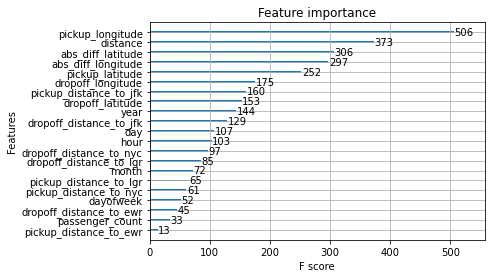

In [8]:
xgb.plot_importance(model)

## Predictions
Read test data from liten, add predicted columns. Prediction is to be added as Liten method as well.

In [9]:
nytaxi_test_file = nytaxi_data_dir+'test.csv'
convert_schema = pa.csv.ConvertOptions(
    column_types={
        'key': 'string',
        'pickup_datetime': 'string',
        'pickup_longitude': 'float32',
        'pickup_latitude': 'float32',
        'dropoff_longitude': 'float32',
        'dropoff_latitude': 'float32',
        'passenger_count': 'uint8'
    }
)
test_pa = pa.csv.read_csv(input_file=nytaxi_test_file, convert_options=convert_schema)
table_name = tc.add_table("nyt_test", test_pa, tc.FactTable)

Added Table= nyt_test


In [10]:
test_pa = tc.slice(table_name="nyt_test", offset=0, length=20)
test_df = test_pa.to_pandas()
test_df = extract_features(test_df)
test_df.dtypes

key                         object
pickup_longitude           float32
pickup_latitude            float32
dropoff_longitude          float32
dropoff_latitude           float32
passenger_count              uint8
abs_diff_longitude         float32
abs_diff_latitude          float32
distance                   float32
pickup_distance_to_nyc     float32
dropoff_distance_to_nyc    float32
pickup_distance_to_jfk     float32
dropoff_distance_to_jfk    float32
pickup_distance_to_ewr     float32
dropoff_distance_to_ewr    float32
pickup_distance_to_lgr     float32
dropoff_distance_to_lgr    float32
year                         int64
month                        int64
day                          int64
dayofweek                    int64
hour                         int64
dtype: object

In [11]:
X_test = test_df.drop(columns='key')
dtest = xgb.DMatrix(X_test, feature_names=X_test.columns)
y_pred = model.predict(dtest)

In [12]:
y_pred.tolist()

[8.8505220413208,
 8.673877716064453,
 5.190378665924072,
 7.9181952476501465,
 13.614038467407227,
 10.36823844909668,
 5.295109748840332,
 46.96551513671875,
 11.048678398132324,
 6.202669620513916,
 9.070849418640137,
 15.976245880126953,
 5.069063663482666,
 7.093703269958496,
 7.8271026611328125,
 11.034036636352539,
 6.520850658416748,
 9.382681846618652,
 5.16073751449585,
 8.701258659362793]

In [13]:
pred_arr = pa.array(y_pred)
test_pa = test_pa.append_column('predicted_fare_amount', pred_arr)

In [14]:
test_pa.to_pandas()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,predicted_fare_amount
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1,8.850522
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1,8.673878
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982521,40.751259,-73.979652,40.746140,1,5.190379
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981163,40.767807,-73.990448,40.751637,1,7.918195
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966049,40.789776,-73.988564,40.744427,1,13.614038
5,2012-12-01 21:12:12.0000005,2012-12-01 21:12:12 UTC,-73.960983,40.765549,-73.979179,40.740051,1,10.368238
6,2011-10-06 12:10:20.0000001,2011-10-06 12:10:20 UTC,-73.949013,40.773205,-73.959625,40.770893,1,5.295110
7,2011-10-06 12:10:20.0000003,2011-10-06 12:10:20 UTC,-73.777283,40.646637,-73.985085,40.759369,1,46.965515
8,2011-10-06 12:10:20.0000002,2011-10-06 12:10:20 UTC,-74.014099,40.709637,-73.995110,40.741364,1,11.048678
9,2014-02-18 15:22:20.0000002,2014-02-18 15:22:20 UTC,-73.969582,40.765518,-73.980682,40.770725,1,6.202670
